In [5]:
%%capture

## Install dependencies
!pip install langchain chromadb sentence-transformers

In [6]:
# Import libraries
import os

from langchain.embeddings import OpenAIEmbeddings, SentenceTransformerEmbeddings 
from langchain.vectorstores import Chroma
from langchain.document_loaders import TextLoader

# Exploratory Data Analysis

In [8]:
# Directory containing chunked files
chunked_dir = "./data/elmundo_chunked_en_page1_15years/"

In [9]:
# Load data set
import pandas as pd
import matplotlib.pyplot as plt

documents = []

for file_name in os.listdir(chunked_dir):
    file_path = os.path.join(chunked_dir, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read().strip()
        documents.append({'file_name': file_name, 'content': content})


df = pd.DataFrame(documents)

In [10]:
# Preview df
df.sample(10)

,file_name,content
719,19490122_1.txt,"THE MIANDO\nWEATHER FORECASTS FOR THE ISLAND, ..."
300,19251121_1.txt,"ELMIJNDO\n1 n PA6S. 3 CIS Oíd"": ""Puerto Km ; A..."
55,19210226_1.txt,"®OW®NDO\n8 flats 3 ctve. vWnWuvi One year,>7.5..."
340,19260904_1.txt,"THE WORLD\n' 1 O 3C7VS. I| | | | I Office: ""Pu..."
570,19460302_1.txt,THE WORLD\n38 Pages 5 Ctvs. 2 Sections\n38 Pag...
281,19250711_1.txt,EL.HÜNÜO\n1 A PASS. 3 CTS. I / II r-i e-f t-i ...
26,19200717_1.txt,THE WORLD\nOMmh Sobredar Brau. ST I TaL S3> P....
603,19461019_1.txt,THE\nWEATHER FORECAST FOR TODAY-Cloudy in the ...
502,19291109_1.txt,THE M&NDO\n18 Pages Ctvs.\n18\nDAILY MORNING\n...
754,19490924_1.txt,"THE MIANDO\nWEATHER FORECASTS FOR THE ISLAND, ..."


# Data Processing

In [12]:
# Basic overview of the dataset
print("\nBasic Dataset Information:\n")
print(df.info())


Basic Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  821 non-null    object
 1   content    821 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB
None


In [13]:
# Check for missing or empty content
missing_content = df['content'].isnull().sum()
print(f"\nNumber of files with missing content: {missing_content}")


Number of files with missing content: 0


In [14]:
# Checking for duplicate content
duplicate_count = df.duplicated(subset=['content']).sum()
print(f"\nNumber of duplicate documents: {duplicate_count}")


Number of duplicate documents: 0


In [15]:
# Document length statistics
df['content_length'] = df['content'].apply(len) # Create a new column with the content length
length_stats = df['content_length'].describe()

print("\nDocument Length Statistics:\n")
print(length_stats)


Document Length Statistics:

count      821.000000
mean     19766.438490
std       5873.254742
min       6340.000000
25%      15527.000000
50%      18631.000000
75%      24750.000000
max      33801.000000
Name: content_length, dtype: float64


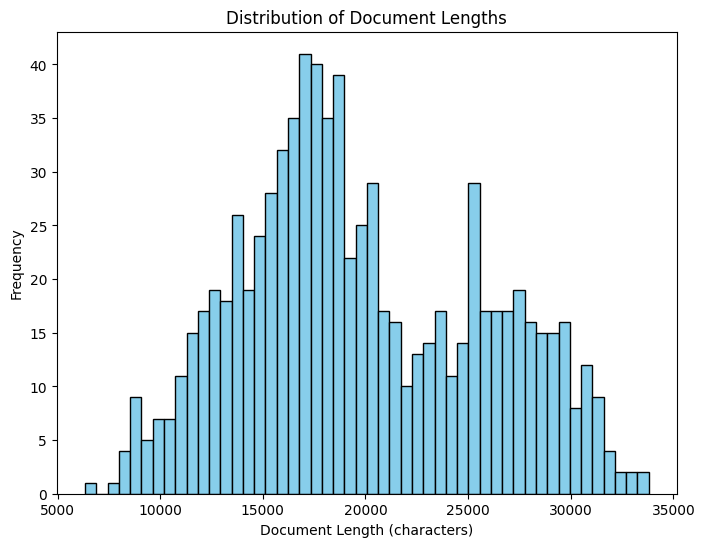

In [16]:
# Distribution plot of document lengths
plt.figure(figsize=(8, 6))
plt.hist(df['content_length'], bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [18]:
# Initialize the RecursiveCharacterTextSplitter
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200, # recomended 10% to 20% from chunk size
    separators=["\n\n", ". ", " "],  # Tries to split by paragraphs first, then sentences, then words
)

print('Splitting chunks ...')

# Split the content efficiently
documents = []

# Split the content efficiently and store metadata - RecursiveCharacterTextSplitter
for index, row in df.iterrows():
    file_name = row['file_name']
    content = row['content']
    chunks = recursive_splitter.split_text(content)
    for chunk in chunks:
        documents.append({"content": chunk, "metadata": {"source": file_name}})

print('Splitting finished.')

Splitting chunks ...
Splitting finished.


# Open AI Approach

In [20]:
# Import OpenAI API key from env file
from dotenv import load_dotenv

openai_api_key = load_dotenv(dotenv_path='openaikey.env')

# Get the API key from the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")

In [21]:
# Intall dependencies
#!pip install langchain-openai

In [22]:
# Import modules
from langchain_openai import OpenAIEmbeddings

In [23]:
# Initialize embedding model
open_ai_embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002', api_key=openai_api_key)

print('ChromaDb Storing process ...')

# Convert to a list of texts and metadata for vectorization
texts = [doc["content"] for doc in documents]
metadatas = [doc["metadata"] for doc in documents]


# Batch insertion function to handle large datasets
def batch_insert_texts(texts, metadatas, open_ai_embedding_model, persist_directory, batch_size=40000):
    """Insert texts and associated metadata in batches to avoid exceeding the maximum batch size."""
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_metadatas = metadatas[i:i + batch_size]
        print(f"Inserting batch {i // batch_size + 1} of size {len(batch_texts)}...")
        Chroma.from_texts(
            batch_texts,
            embedding=open_ai_embedding_model,
            metadatas=batch_metadatas,
            persist_directory=persist_directory
        )


# Insert texts and metadata in batches
batch_insert_texts(
    texts=texts,
    metadatas=metadatas,
    open_ai_embedding_model=open_ai_embedding_model,
    persist_directory="./chroma_db",
    batch_size=40000  # Adjust batch size if necessary
)

print("Chunks have been successfully split, vectorized, and stored in the vector database.")

ChromaDb Storing process ...
Inserting batch 1 of size 20965...
Chunks have been successfully split, vectorized, and stored in the vector database.


In [24]:
# Test query output as vectors 
user_query = "What industry contributes the most to the Puerto Rican economy?"

text_embedding_ada_vector = open_ai_embedding_model.embed_query(user_query)

print(f"Text Embedding ADA 002 Embedding Vector: {text_embedding_ada_vector[0:30]}")

Text Embedding ADA 002 Embedding Vector: [-9.969390521291643e-05, -0.02118777669966221, 0.011862811632454395, -0.02057608962059021, -0.022072769701480865, -0.01704913191497326, 0.00205956120043993, 0.020940497517585754, -0.002923405496403575, -0.039121899753808975, 0.006897740066051483, 0.020901454612612724, 0.01643744483590126, 0.0009126491495408118, -0.008459492586553097, 0.0015715134795755148, 0.012324830517172813, -0.010496278293430805, 0.0014202187303453684, -0.01594289019703865, -0.03412429243326187, 0.031755633652210236, 0.004568126052618027, -0.016580605879426003, 0.02582097426056862, 0.0314432829618454, 0.019495876505970955, -0.003575762500986457, -0.006660223938524723, -0.014146874658763409]


In [42]:
# Load the persisted ChromaDB
vector_db = Chroma(persist_directory="./chroma_db", embedding_function=open_ai_embedding_model)

C:\Users\Jarian\AppData\Local\Temp\ipykernel_31264\1807372177.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(persist_directory="./chroma_db", embedding_function=open_ai_embedding_model)


In [49]:
# Example user query
query = "What industry contributes the most to the Puerto Rican economy?"

# Retrieve the top 5 most relevant chunks
results = vector_db.similarity_search(query, k=10)

# Extract the content of the retrieved documents
context = "\n\n".join([result.page_content for result in results])

# Check if context was retrieved
if not context:
    context = "No relevant information found."
    
# Display the results
for idx, result in enumerate(results):
    print(f"\nDocument {idx + 1}:")
    print(f"Source: {result.metadata.get('source', 'Unknown')}")
    print(f"Content: {result.page_content[:300]}...")  # Display only the first 300 characters


Document 1:
Source: 19210917_1.txt
Content: . As far as housing is concerned, it is well demonstrated that the Puerto Rican people are in favor of having a comfortable, clean home with all the modern conveniences. 1 As far as clothing is concerned, there is no doubt that we like to dress in the latest fashions, just as in any other civilized ...

Document 2:
Source: 19471025_1.txt
Content: . The sudden drop in exports found the industry operating at an accelerated volume, and with considerable reserves in the possession of its continental distributors. Although there is hope that a favorable change in the present situation may arise, there is little optimism among Puerto Rican industr...

Document 3:
Source: 19500121_1.txt
Content: . 1 There are, however, two or three factors of much greater importance to the island economy than to the national one. "The size of the cane crop and the amount of cane that can be sold at a remunerative price is of great significance to our economy. In th

# Querying the data

In [62]:
# Load GPT model
gpt_model = "gpt-4o-mini" 

# Build the prompt
def build_prompt(query, context):
    return f"""
    ## INTRODUCTION
    You are a Chatbot designed to help answer questions about Puerto Rico.
    The user asked: "{query}"
    
    ## CONTEXT
    News Documentation:
    '''
    {context}
    '''
    
    ## RESTRICTIONS
    Refer to the news by their titles.
    Be clear, transparent, and factual: only state what is in the context without providing opinions or subjectivity.
    Answer the question based solely on the context above; if you do not know the answer, be clear with the user that you do not know.
    Only respond to questions related to the products, avoiding jokes, offensive remarks, and discussions on religion or sexuality.
    If the user does not provide sufficient context, do not answer and instead ask for more information on what the user wants to know.
    
    ## TASK
    First, answer directly to the user, if possible.
    Second, point the user in the right direction of the documentation.
    Lastly, answer in Markdown format.
    
    ## RESPONSE STRUCTURE:
    # About [Answer Title]
    [answer text]
    
    ### Source:
    • source_section <br>
    • source_section <br>
        
    ## CONVERSATION:
    User: {query}
    Agent:
    """

In [64]:
import openai
import markdown
from IPython.display import display, Markdown

def generate_response_with_openai(query, k=10):
    # Search the Top 10 Relevants Chunks in ChromaDB
    results = vector_db.similarity_search(query, k=k)
    
    # Join the Chunk as one Context
    context = "\n".join([result.page_content for result in results])
    
    # Create the Prompt for OpenAI   
    # Prepare the messages payload
    prompt = build_prompt(query, context)
    message = [{'role': 'user', 'content': prompt}]
    
    #model_params = {'model': gpt_model, 'temperature': 0.4, 'max_tokens': 3000}
    
    response = openai.chat.completions.create(
        messages=message,
        model=gpt_model,
        temperature=0.4,
        max_tokens=3000
    )
      
    return response.choices[0].message.content

# ChatBot
print('Welcome to Puerto Rico News')
print('Enter a question or type "exit" to quit. ')
while True:
    query = input("\nYou: ")
    if len(query) > 10:
        response = generate_response_with_openai(query)
        markdown_response = markdown.markdown(response)
        print("AI: ")
        display(Markdown(markdown_response)) # markdown output
    elif query.lower() == 'exit':
        break

print("Thanks!")

Welcome to Puerto Rico News
Enter a question or type "exit" to quit. 



You:  Who is the govenor of Puerto Rico?


AI: 


<h1>About the Governor of Puerto Rico</h1>
<p>The current Governor of Puerto Rico is Mr. Jesús T. Piñero.</p>
<h3>Source:</h3>
<p>• The Governor of Puerto Rico is appointed by the President of the United States, with the consent of the Senate. <br>
• The Office of House Representative Antonio Pacheco Padró has sent the Honorable Governor of Puerto Rico, Mr. Jesús T. Piñero, through the Speaker of the House.</p>


You:  What are the main economic industries in Puerto Rico?


AI: 


<h1>About Main Economic Industries in Puerto Rico</h1>
<p>The main economic industries in Puerto Rico include agriculture, manufacturing, and commerce. Specific sectors mentioned are the canning industry, coffee processing, foundries, and the production of sugar, rum, and tobacco. Additionally, the island has seen significant investments in food, motor vehicles, and construction materials. However, there are concerns about the agricultural sector's ability to support the population without the establishment of other industries.</p>
<h3>Source:</h3>
<p>• "Island's biggest investments were in food and vehicles" <br>
• "The main problem of all the industries we have visited is that they have old equipment" <br>
• "The agricultural interests of the Island will not be able to support the population of Puerto Rico" <br></p>


You:  Where in the documentation does it say that Puerto Rico has a strong pharmaceutical industry?


AI: 


<h1>About Puerto Rico's Pharmaceutical Industry</h1>
<p>The documentation mentions that Puerto Rico has a strong pharmaceutical industry by highlighting the existence of companies like The Porto Rico Drug Company, which emphasizes the high quality of chemicals used in their products and their competitive pricing. Additionally, it notes the island's capability to prepare drugs and pharmaceutical preparations with raw materials sourced locally and abroad.</p>
<h3>Source:</h3>
<p>• "THE PORTO RICO DRUG COMPANY" <br>
• "The island to prepare with the raw materials that exist in Puerto Rico, drugs and pharmaceutical preparations that are generated both here and abroad" <br></p>


You:  Does Puerto Rico export more coffee or electronics?


AI: 


<h1>About Puerto Rico's Exports</h1>
<p>The context provided does not contain specific data comparing the exports of coffee and electronics from Puerto Rico. Therefore, I cannot definitively answer whether Puerto Rico exports more coffee or electronics.</p>
<h3>Source:</h3>
<p>• News Documentation on coffee exports <br>
• General export statistics not specified in the context</p>


You:  Is Puerto Rico better off as a U.S. territory or as an independent country?


AI: 


<h1>About Puerto Rico's Political Status</h1>
<p>The question of whether Puerto Rico is better off as a U.S. territory or as an independent country is complex and involves various perspectives. According to the context provided, many Puerto Ricans believe that their association with the United States has been beneficial, with 90 percent of the population supporting this view. However, there is also a strong sentiment against living under a colonial system, with calls for self-governance and independence being prominent.</p>
<p>The former governor, Jesús T. Piñero, indicated that a decision regarding independence might not be feasible for another ten to fifteen years, suggesting that industrialization is a prerequisite for such a choice. Additionally, the context outlines that Puerto Rico's economic situation is challenging, and its future political status remains uncertain, with discussions ongoing about statehood, independence, or a modified territorial status.</p>
<h3>Source:</h3>
<p>• The internal situation of Puerto Rico and the views of its leaders <br>
• The perspectives on independence and economic realities <br></p>


You:  List three key takeaways from Puerto Rico's latest financial report.


AI: 


<h1>About Key Takeaways from Puerto Rico's Latest Financial Report</h1>
<ol>
<li>
<p><strong>Instability of Federal Revenues</strong>: The main source of income for the Treasury, federal revenues, has been characterized by instability, particularly affecting the rum industry, which complicates the establishment of a stable financial framework.</p>
</li>
<li>
<p><strong>Projected Revenue Estimates</strong>: The estimated income for the next fiscal year is projected to be approximately $71,952,338, which aligns with prior estimates from the Planning Board.</p>
</li>
<li>
<p><strong>Public Sentiment and Economic Concerns</strong>: The Auditor of Puerto Rico's report has generated a gloomy outlook on the financial situation, highlighting terms like "bankruptcy," "insolvency," and "economic disaster," which have contributed to public panic among employees.</p>
</li>
</ol>
<h3>Source:</h3>
<p>• News Documentation <br>
• News Digest <br></p>


You:  Provide details about Puerto Rico’s space exploration program.


AI: 


<h1>About Puerto Rico’s Space Exploration Program</h1>
<p>The context provided does not contain specific details about a space exploration program in Puerto Rico. It mentions various engineering and industrial initiatives, but there is no direct reference to space exploration or related activities.</p>
<h3>Source:</h3>
<p>• News Documentation (general context) <br>
• No specific section on space exploration found.</p>


You:  exit


Thanks!


# Queries to test model responses

1. Basic Fact Checking and Accuracy
- Question- Who is the current govenor of Puerto Rico?
- Question- What are the main insudtries in Puerto Rico?

2. Citation and Source Attribution
- Question- Where in the documentation does it say that Puerto Rico has a strong pharmaceutical industry?

3. Edge Cases and Robustness
- Question- Does Puerto Rico export more coffee or electronics?

4. Bias and ethical testing
- Question: Is Puerto Rico better off as a U.S. Territory or as an independent country?

5. Formatting and response structure
- Question: List three key takeaways from Puerto Rico's latest financial report.

6. Hallucination Detection
- Question: Provide information about Puerto Rico's space program